In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import talib

from backtesting import Backtest, Strategy 
from backtesting.lib import crossover
from backtesting.test import SMA

/opt/conda/lib/python3.9/site-packages/backtesting/_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
tickers = ["NVDA", "VOO", "VUG", "SE", "CRWD", "TSM", "MSFT"]
hist = yf.download(
    tickers=" ".join(tickers),
    period="2y",
    # group_by="ticker"
)

[*********************100%***********************]  7 of 7 completed


In [3]:
hist['Adj Close']

,CRWD,MSFT,NVDA,SE,TSM,VOO,VUG
Date,,,,,,,
2019-06-24,67.970001,134.799957,152.058212,34.189999,38.107178,261.347595,161.681015
2019-06-25,61.520000,130.544037,150.882843,33.419998,37.096825,258.763611,159.273712
2019-06-26,62.650002,131.033249,158.632156,33.810001,37.249325,258.512939,159.450577
2019-06-27,63.279999,131.248459,162.586533,33.770000,37.735443,259.420135,160.221863
2019-06-28,68.290001,131.062592,163.582581,33.220001,37.335114,260.854492,160.950821
...,...,...,...,...,...,...,...
2021-06-18,244.910004,259.429993,745.549988,282.489990,115.790001,382.820007,277.059998
2021-06-21,237.679993,262.630005,737.090027,281.059998,114.139999,388.179993,279.420013
2021-06-22,256.609985,265.510010,755.469971,280.869995,114.330002,390.239990,282.329987


In [4]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [5]:
mu = expected_returns.mean_historical_return(hist['Adj Close'])
S = risk_models.sample_cov(hist['Adj Close'])

In [6]:
mu

CRWD    0.931733
MSFT    0.405729
NVDA    1.247955
SE      1.915418
TSM     0.749383
VOO     0.224087
VUG     0.325632
dtype: float64

In [7]:
S

,CRWD,MSFT,NVDA,SE,TSM,VOO,VUG
CRWD,0.430108,0.095570,0.146399,0.159748,0.084159,0.058627,0.080635
MSFT,0.095570,0.116725,0.132307,0.109550,0.081292,0.076213,0.086777
NVDA,0.146399,0.132307,0.245717,0.163393,0.125613,0.095127,0.112493
SE,0.159748,0.109550,0.163393,0.341583,0.110109,0.078071,0.096153
TSM,0.084159,0.081292,0.125613,0.110109,0.156807,0.066074,0.072992
VOO,0.058627,0.076213,0.095127,0.078071,0.066074,0.067572,0.068435
VUG,0.080635,0.086777,0.112493,0.096153,0.072992,0.068435,0.075643


In [8]:
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.csv")
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('CRWD', 0.0), ('MSFT', 0.0), ('NVDA', 0.29279), ('SE', 0.70721), ('TSM', 0.0), ('VOO', 0.0), ('VUG', 0.0)])
Expected annual return: 172.0%
Annual volatility: 50.9%
Sharpe Ratio: 3.34


(1.7199929126878906, 0.5094817056515523, 3.3367104134069923)

In [9]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [10]:
latest_prices = get_latest_prices(hist['Adj Close'])

In [11]:
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10_000)
allocation, leftover = da.greedy_portfolio()

In [12]:
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'SE': 24, 'NVDA': 3}
Funds remaining: $683.23


Expected annual return: 171.6%
Annual volatility: 50.8%
Sharpe Ratio: 3.34


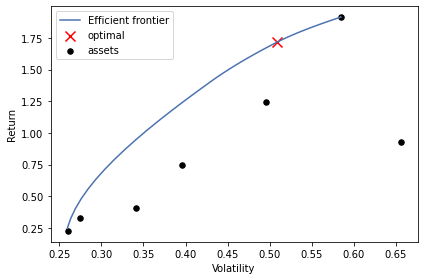

In [13]:
from pypfopt.efficient_frontier import EfficientFrontier#, 
#objective_functions
from pypfopt import risk_models, expected_returns, CLA, plotting


days = 252
mu = expected_returns.mean_historical_return(hist["Adj Close"], frequency=days)
S =risk_models.sample_cov(hist["Adj Close"], frequency=days)
cla = CLA(mu, S)
cla.max_sharpe()
cla.portfolio_performance(verbose=True)
ax = plotting.plot_efficient_frontier(cla, showfig=False)


In [14]:
pd.DataFrame(cla.weights, index=hist["Adj Close"].columns)

,0
CRWD,0.000000e+00
MSFT,0.000000e+00
NVDA,2.981511e-01
SE,7.018489e-01
TSM,-6.098149e-17
VOO,0.000000e+00
VUG,0.000000e+00


In [15]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
import math
import numpy as np

In [16]:
risks = (hist["Adj Close"].pct_change().dropna(how="all")).std() # 各株ごとの平均リスク（標準偏差）の計算
risks = ((risks * risks) * days).apply(math.sqrt) # 指定期間での各株ごとのリスク（標準偏差）の計算


In [47]:
risks

CRWD    0.655825
MSFT    0.341646
NVDA    0.495684
SE      0.584148
TSM     0.395992
VOO     0.259951
VUG     0.275028
dtype: float64

In [17]:
plot_df = pd.DataFrame()

plot_df["symbol"] = mu.index
plot_df["risk"] = risks.values
plot_df["return"] = mu.values

ef = EfficientFrontier(mu, S)

In [18]:
trets = np.arange(round(np.amin(mu), 3), round(np.amax(mu), 3), 0.01)
tvols = []
res_ret = []
res_risk = []
weight_df = pd.DataFrame(columns=mu.index, index=trets)

In [20]:
trets.shape

(170,)

In [21]:
for i, tr in enumerate(trets):
    if i % 10 == 0:
        print(i)
    try:
        w = ef.efficient_return(target_return=tr)
        w = ef.clean_weights()
        pref = ef.portfolio_performance()
        res_ret += [pref[0]]
        res_risk += [pref[1]]
        weight_df.loc[tr, :] = list(w.values())

    except:
        print(tr, "error")



0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160


In [25]:
from plotly import graph_objects as go

In [30]:
front_line = pd.DataFrame({"risk": res_risk, "return": res_ret})

layout = go.Layout(
    xaxis = {"title": "risk(%)"},
    yaxis = {"title": "return(%)"}
)

fig = go.Figure(layout=layout)

fig.add_trace(
    go.Scatter(
        x=plot_df["risk"]*100,
        y=plot_df["return"]*100,
        mode="markers+text",
        text=plot_df["symbol"],
        textposition="top center"
    )
)

fig.add_trace(
    go.Scatter(
        x=front_line["risk"]*100,
        y=front_line["return"]*100,
        mode="lines"
    )
)

fig.show()

In [35]:
layout = go.Layout(
    xaxis={"title": "return (%)"},
    yaxis={"title": "weight (%)"},
    hovermode="x"
)

fig = go.Figure(layout=layout)

for col in weight_df:
    fig.add_trace(
        go.Scatter(
            x=weight_df.index*100, y=weight_df[col]*100,
            # hoverinfo="x+y",
            mode="lines",
            line={"width": 0.5},
            name=col,
            stackgroup="one"
        )
    )

fig.show()